# Configurer votre colab pour le calcul sur GPU
Dans le menu au dessus, choisir le sous-menu **Exécution** puis l'option **Modifier le type d'exécution**.

Une fenêtre apparaît où vous pouvez choisir un accélérateur matériel. Choisissez un *GPU* puis *enregistrer* votre choix.

Afin de vérifier que vous avez bien configuré votre session pour utiliser un GPU, exécuter le code ci-dessous (en passant la souris, une petite flèche pour l'exécuter apparaît).

Si tout se passe bien, un tableau (en ascii) apparaît avec le type de carte (et son architecture) auquel vous avez accès. Si un message d'erreur apparaît, vérifiez dans **Modifier le type d'exécution** que l'accélérateur matériel est bien configuré pour un *GPU*

In [2]:
!nvidia-smi

Tue Mar  4 14:18:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Installation de PyCuda

Pour utiliser le GPU sous Python il faut soit installer **PyCuda** pour effectuer des calculs, soit **PyTorch** pour effectuer du machine learning accéléré par les GPUs.

Dans ce TP, nous nous bornerons uniquement à effectuer des calculs sur GPU !

Pour cela, il faut d'abord installer pyCuda et donc exécuter le code ci-dessous (toujours en appuyant sur la flèche pour exécuter le code, et attendez, cela prend un petit moment...)

In [3]:
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.8/92.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 8.1 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2025.1-cp311-cp311-linux_x86_64.whl size=660393 sha256=776a05261c349ff4f585a55053d5765a6e385631824eb9ef3d124ab4f438d0cf
  Stored in directory: /root/.cache/pip/wheels/77/7e/6c/d2d1451ea6424cdc3d67b36c16fa7111eafdf2034bc3405666
Successfully built pycuda


# Vérification du bon fonctionnement du module PyCuda

Afin de vérifier le bon fonctionnement de l'installation, nous allons écrire un script Cuda qui servira en même temps d'exemple pour le TP d'aujourd'hui. Ce script sera scindé en plusieurs morceaux et commenté pour que vous compreniez chaque partie du code.

Ce code sera très simple : on va créer une matrice 4x4 avec des données prises "au hasard" (mais avec une graine aléatoire fixée, donc...) , recopier ce tableau dans la mémoire de la carte graphique et demander à la carte graphique de doubler la valeur de chaque élément de la matrice puis de recopier dans la mémoire de l'ordinateur les valeurs calculées. On affiche ensuite la matrice initiale et la matrice transformée.

Dans un premier temps, chargeons les modules python nécessaire à l'exécution d'un noyau Cuda (**Remarque** : l'importation de ces modules n'est nécessaire qu'une seule fois pour **TOUTE** la session. Il sera donc inutile de reimporter ces modules dans le reste du TD !) :

In [4]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

Créons à l'aide de numpy un tableau *a* dont les valeurs aléatoires sont issues d'une graine fixée :

In [5]:
import numpy
numpy.random.seed(1729)
a = numpy.random.randn(4,4) # Sous forme de matrice 4 x 4

Puisque certaines cartes graphiques supportent mal le double précision, nous allons demander à Python que les éléments de *a* soient en simple précision :

In [6]:
a = a.astype(numpy.float32)
print(a.nbytes)

64


Nous allons ensuite allouer de la place mémoire sur la mémoire vive du GPU. Comme en C, la place mémoire est exprimée en *Octets* :

In [7]:
a_gpu = cuda.mem_alloc(a.nbytes)

Une fois la réservation sur le GPU de faite, on recopie les valeurs de *a* dans le tableau *a_gpu* que l'on vient de réserver (htod signifie host **to** device):

In [8]:
cuda.memcpy_htod(a_gpu, a)

Il faut ensuite écrire le noyau qui s'exécutera sur la carte graphique à l'aide du langage CUDA (qui est une extension du langage C).

**Remarquez** dans le code qu'on s'assure que les indices donnés par les numéros de threads ne dépassent pas la dimension de la matrice !

In [9]:
mod = SourceModule("""
__global__ void doublify( int dim_x, int dim_y, float *a )
{
  if ((threadIdx.x < dim_x) && (threadIdx.y < dim_y))
  {
    int idx = threadIdx.x + threadIdx.y * dim_x;
    a[idx] *= 2;
  }
}
""")

Nous allons récupérer ensuite un "handle" sur le noyau cuda que l'on vient de créer (en invoquant le nom de la fonction) et l'invoquer sur la carte graphique en dimensionnant la grille de calcul à l'aide de *block=(4,4,1)* (et en l'adaptant aux dimensions de la matrice).

Ici, nous n'avons pas besoin de configurer de grilles car la dimension de la matrice *a* est petite, mais comme la taille d'un bloc dans une direction est limitée à 256, pour des cas plus gros, il faudra également passer une grille en paramètre à l'aide de *grid=(x,y,z)* où *x,y* et *z* sont des valeurs entières positives et utiliser dans le noyau cuda les valeurs *x,y* et *z* de **blockIdx** et **blockDim**.

**REMARQUE IMPORTANTE** : Le noyau cuda ne veut que des types C basiques en argument. Or un entier python est tout sauf un type basique du C. Donc pour passer un argument entier à un noyau cuda, il faut créer un entier 32 bits à l'aide de numpy.int32

In [10]:
func = mod.get_function("doublify")
dim = numpy.int32(4)
func(dim, dim, a_gpu, block=(4,4,1))

Il ne reste plus qu'à récupérer les nouvelles valeurs de la matrice en transférant les données de la matrice contenue par le GPU dans un tableau numpy se trouvant dans la RAM de l'ordinateur (dtoh signifie device **to** host) :

In [11]:
a_doubled = numpy.empty_like(a)
cuda.memcpy_dtoh(a_doubled, a_gpu)

Il ne reste plus qu'à afficher la matrice initiale puis la matrice obtenue par le calcul sur GPU :

In [12]:
print(f"a : {a}")
print(f"a_gpu : {a_doubled}")

a : [[-0.6873394  -0.82099473  1.6523609  -0.57529306]
 [ 1.0989678   0.92594606 -0.9934138  -0.8582211 ]
 [ 0.07488676  0.5293555   0.12095155 -0.22442362]
 [-1.5566785   0.05594088  0.16147153 -2.1346416 ]]
a_gpu : [[-1.3746789  -1.6419895   3.3047218  -1.1505861 ]
 [ 2.1979356   1.8518921  -1.9868276  -1.7164422 ]
 [ 0.14977352  1.058711    0.2419031  -0.44884723]
 [-3.113357    0.11188176  0.32294306 -4.2692833 ]]


## Exercices de mises en bouche

En vous inspirant du programme commenté ci-dessus, écrivez un code avec un noyau Cuda qui fait la somme de deux vecteurs de réels simples précisions et qui range le résultat dans un troisième vecteur.

On s'exercera à utiliser des vecteurs de "grandes" dimensions (> 256) afin de s'entrainer à calculer des indices globaux dans le noyau cuda à l'aide de *threadIdx.x*, *blockIdx.x* et *dimBlock.x*.

Ecrivez (ou copier coller) votre code dans la cellule ci-dessous

In [13]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy as np

# Définition de la fonction noyau CUDA
mod = SourceModule("""
__global__ void vectorAdd(const float* a, const float* b, float* c, int n) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < n) {
        c[i] = a[i] + b[i];
    }
}
""")

# Obtenir le gestionnaire de fonction noyau
vector_add = mod.get_function("vectorAdd")

# Définir la longueur du vecteur
n = 1000  # Longueur du vecteur > 256
block_size = 256  # Nombre de threads par bloc
grid_size = (n + block_size - 1) // block_size  # Taille de la grille

# Créer des données hôte
a = np.random.randn(n).astype(np.float32)
b = np.random.randn(n).astype(np.float32)
c = np.zeros(n, dtype=np.float32)

# Allouer la mémoire sur le périphérique
a_gpu = cuda.mem_alloc(a.nbytes)
b_gpu = cuda.mem_alloc(b.nbytes)
c_gpu = cuda.mem_alloc(c.nbytes)

# Copier les données de l'hôte vers le périphérique
cuda.memcpy_htod(a_gpu, a)
cuda.memcpy_htod(b_gpu, b)

# Appeler la fonction noyau
vector_add(a_gpu, b_gpu, c_gpu, np.int32(n), block=(block_size, 1, 1), grid=(grid_size, 1))

# Copier le résultat du périphérique vers l'hôte
cuda.memcpy_dtoh(c, c_gpu)

# Vérifier les résultats
print("a:", a)
print("b:", b)
print("c (a + b):", c)

# Libérer la mémoire sur le périphérique
a_gpu.free()
b_gpu.free()
c_gpu.free()

a: [ 1.09670043e-01  4.43012148e-01  3.96266222e-01  2.49797404e-01
  1.29849732e+00 -1.28043365e+00 -9.75465834e-01 -2.69086629e-01
 -1.10573840e+00 -1.27992705e-01 -6.17827356e-01 -9.89126265e-01
 -2.85989237e+00 -7.94347525e-01 -3.05796951e-01  1.70063758e+00
 -6.35444164e-01  4.57386579e-03  1.13330400e+00  1.41641274e-01
  2.09171796e+00 -1.26955926e+00 -7.22823381e-01 -1.93888936e-02
 -1.82823569e-01 -1.11906576e+00 -6.98275089e-01  2.10708451e+00
 -2.55559874e-03  4.09010053e-01  2.83636749e-01 -1.94985449e+00
  3.86030883e-01  2.30641112e-01 -1.18697083e+00 -6.66551590e-01
  1.79776692e+00  6.63798332e-01  1.12381160e+00 -1.13430619e+00
  1.18444979e+00  7.01262355e-01  4.55496371e-01 -8.14868957e-02
 -1.09586859e+00  4.40716892e-01  1.64270854e+00  4.47959393e-01
 -7.86716700e-01 -1.73142985e-01  2.31948209e+00 -3.28604549e-01
 -2.38856971e-01 -2.16715157e-01  9.87426937e-01  1.80691957e+00
 -5.64313769e-01  5.43536484e-01  5.42878568e-01  2.07137957e-01
 -2.31273577e-01  2.82

Une fois le code mis au point, recopiez le ci-dessous et adaptez le pour additionner deux matrices carrées dans une troisième.

In [14]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy as np

# Définir le noyau CUDA
mod = SourceModule("""
__global__ void matrixAdd(const float* A, const float* B, float* C, int N) {
    int i = blockIdx.y * blockDim.y + threadIdx.y;
    int j = blockIdx.x * blockDim.x + threadIdx.x;

    if (i < N && j < N) {
        int index = i * N + j;
        C[index] = A[index] + B[index];
    }
}
""")

# Obtenir le gestionnaire de noyau
matrix_add = mod.get_function("matrixAdd")

# Définir la taille de la matrice
N = 512  # La taille de la matrice est N x N
block_size = 16  # La taille de chaque bloc de threads est 16x16
grid_size = (N + block_size - 1) // block_size  # Taille de la grille

# Créer des données hôte
A = np.random.randn(N, N).astype(np.float32)
B = np.random.randn(N, N).astype(np.float32)
C = np.zeros((N, N), dtype=np.float32)

# Allouer la mémoire du périphérique
A_gpu = cuda.mem_alloc(A.nbytes)
B_gpu = cuda.mem_alloc(B.nbytes)
C_gpu = cuda.mem_alloc(C.nbytes)

# Copier les données de l'hôte vers le périphérique
cuda.memcpy_htod(A_gpu, A)
cuda.memcpy_htod(B_gpu, B)

# Appeler le noyau
matrix_add(A_gpu, B_gpu, C_gpu, np.int32(N),
           block=(block_size, block_size, 1),
           grid=(grid_size, grid_size))

# Copier le résultat du périphérique vers l'hôte
cuda.memcpy_dtoh(C, C_gpu)

# Vérifier le résultat
print("A:")
print(A)
print("B:")
print(B)
print("C (A + B):")
print(C)

# Libérer la mémoire du périphérique
A_gpu.free()
B_gpu.free()
C_gpu.free()

/usr/local/lib/python3.11/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  globals().clear()


A:
[[ 0.6491703   0.02842279  0.4239559  ...  0.6944459  -0.73741466
   1.9109453 ]
 [-1.1493797   1.2387758  -1.0794804  ... -0.9646004  -0.45415694
  -1.6813704 ]
 [-0.7660116  -0.04341931 -1.4604155  ...  0.10141992 -1.6964866
   1.0645583 ]
 ...
 [ 0.74834234 -1.2775562  -0.49206606 ...  0.13428149 -0.5175669
   0.12634541]
 [ 2.7894394  -0.68125117  0.5023889  ...  0.8090733  -0.02937344
   0.8193425 ]
 [ 0.463411   -1.0317569   1.8743435  ... -0.09762269 -1.4517003
  -0.9535357 ]]
B:
[[-1.3379244  -0.27734247 -0.59263885 ... -0.17128855 -0.47332114
  -0.09856115]
 [-0.24069338  0.3554258   0.4547094  ...  0.77247196 -0.1448493
  -0.7648795 ]
 [ 0.79242545  0.47308552  0.45149657 ... -0.48142236  1.5993525
  -0.76104814]
 ...
 [ 0.3378476  -0.5227418  -1.8744686  ... -0.98052245  1.5456102
  -1.4854084 ]
 [-0.58728343  1.0162324  -0.01632553 ...  0.7306621  -1.9853183
  -1.1841241 ]
 [-0.01624833  0.05216777  1.4812425  ...  1.1611826   1.1348096
  -0.3825647 ]]
C (A + B):
[[-0.68

# Exercice final

Nous allons de nouveau nous intéresser à l'ensemble de Mandelbrot. La cellule ci-dessous contient un code permettant de calculer à l'aide de numpy un ensemble de mandelbrot (le code est simplifié par rapport aux codes sur CPU pour faciliter le TP même si il utilise la notation vectorielle de numpy (il faudra y faire attention pour code le noyau cuda !) : code repris de https://stackoverflow.com/questions/60467316/displaying-mandelbrot-set-in-python-using-matplotlib-pyplot-and-numpy).

Transformez le de sorte que sur GPU, chaque thread calcule un pixel de l'image de destination.

<ipython-input-15-cfd8db56f87f>:18: RuntimeWarning: overflow encountered in square
  z = z**2 + c
<ipython-input-15-cfd8db56f87f>:18: RuntimeWarning: invalid value encountered in square
  z = z**2 + c


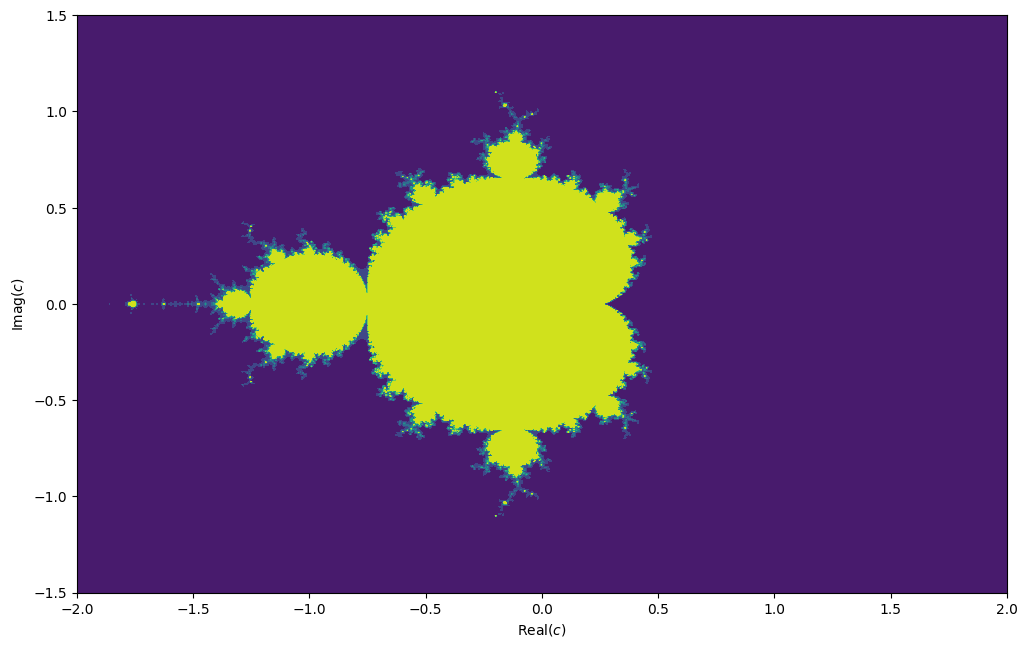

In [15]:
import pylab as plt
import numpy as np
# initial values
loop = 100 # number of interations
div = 1000 # divisions
# all possible values of c
c = np.linspace(-2,2,div)[:,np.newaxis] + 1j*np.linspace(-1.5,1.5,div)[np.newaxis,:]
# array of ones of same dimensions as c
ones = np.ones(np.shape(c), int)
# Array that will hold colors for plot, initial value set here will be
# the color of the points in the mandelbrot set, i.e. where the series
# converges.
# For the code below to work, this initial value must at least be 'loop'.
# Here it is loop + 5
color = ones * loop + 5
z = 0
for n in range(0,loop):
      z = z**2 + c
      diverged = np.abs(z)>2
      # Store value of n at which series was detected to diverge.
      # The later the series is detected to diverge, the higher
      # the 'color' value.
      color[diverged] = np.minimum(color[diverged], ones[diverged]*n)

plt.rcParams['figure.figsize'] = [12, 7.5]
# contour plot with real and imaginary parts of c as axes
# and colored according to 'color'
plt.contourf(c.real, c.imag, color)
plt.xlabel("Real($c$)")
plt.ylabel("Imag($c$)")
plt.xlim(-2,2)
plt.ylim(-1.5,1.5)
plt.savefig("plot.png")
plt.show()

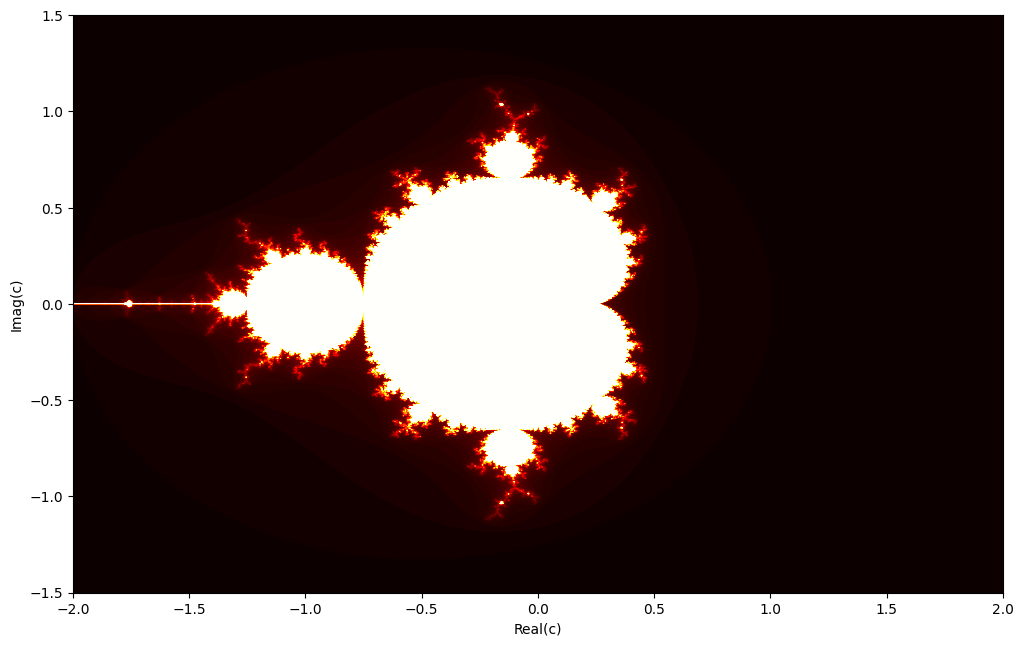

In [16]:
import pycuda.driver as cuda
import pycuda.autoinit  # Initialisation automatique du pilote CUDA
from pycuda.compiler import SourceModule
import numpy as np
import matplotlib.pyplot as plt

# Paramètres
width = 1000    # Largeur de l'image (correspondant à la division de l'axe réel du plan complexe)
height = 1000   # Hauteur de l'image (correspondant à la division de l'axe imaginaire du plan complexe)
max_iter = 100  # Nombre maximal d'itérations
x_min, x_max = -2.0, 2.0    # Plage de l'axe réel
y_min, y_max = -1.5, 1.5    # Plage de l'axe imaginaire

# Allocation du tableau de résultats sur l'hôte (CPU), type de données float32
result = np.zeros((height, width), dtype=np.float32)

# Code du noyau CUDA
kernel_code = """
__global__ void mandelbrot(float *result, float x_min, float x_max, float y_min, float y_max,
                           int width, int height, int max_iter) {
    // Calcul des indices de thread 2D
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    int idy = blockIdx.y * blockDim.y + threadIdx.y;

    // Vérification des limites de l'image
    if (idx >= width || idy >= height) return;

    int index = idy * width + idx;

    // Mapping des coordonnées des pixels sur le plan complexe
    float real = x_min + idx * (x_max - x_min) / width;
    float imag = y_min + idy * (y_max - y_min) / height;

    // Initialisation des nombres complexes c et z (z initialisé à 0)
    float c_re = real;
    float c_im = imag;
    float z_re = 0.0;
    float z_im = 0.0;

    int iter;
    // Calcul de l'ensemble de Mandelbrot : z = z^2 + c
    for (iter = 0; iter < max_iter; iter++) {
        // Calcul de z_re^2 et z_im^2
        float z_re2 = z_re * z_re;
        float z_im2 = z_im * z_im;
        // Condition de divergence si le module au carré est supérieur à 4
        if (z_re2 + z_im2 > 4.0)
            break;
        // Calcul des nouvelles parties réelle et imaginaire de z
        float new_re = z_re2 - z_im2 + c_re;
        float new_im = 2.0 * z_re * z_im + c_im;
        z_re = new_re;
        z_im = new_im;
    }

    // Stockage du nombre d'itérations avant divergence
    result[index] = (float) iter;
}
"""

# Compilation du noyau
mod = SourceModule(kernel_code)
mandelbrot = mod.get_function("mandelbrot")

# Allocation de la mémoire sur le périphérique (GPU) pour le tableau result
result_gpu = cuda.mem_alloc(result.nbytes)

# Configuration des blocs et de la grille (exemple : blocs de 16x16 threads)
block_dim = (16, 16, 1)
grid_dim = ( (width + block_dim[0] - 1) // block_dim[0], (height + block_dim[1] - 1) // block_dim[1] )

# Lancement du noyau CUDA avec les paramètres requis
mandelbrot(result_gpu,
           np.float32(x_min), np.float32(x_max), np.float32(y_min), np.float32(y_max),
           np.int32(width), np.int32(height), np.int32(max_iter),
           block=block_dim, grid=grid_dim)

# Copie du résultat de la mémoire du GPU vers la mémoire du CPU
cuda.memcpy_dtoh(result, result_gpu)

# Affichage de l'ensemble de Mandelbrot (transposition du tableau pour correspondre aux axes)
plt.figure(figsize=(12, 7.5))
plt.contourf(np.linspace(x_min, x_max, width), np.linspace(y_min, y_max, height), result, levels=100, cmap="hot")
plt.xlabel("Réel(c)")
plt.ylabel("Imaginaire(c)")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.savefig("mandelbrot_pycuda.png")
plt.show()